<a href="https://colab.research.google.com/github/NourElhouda-ELB/Image-Scene-Classification-MobileNet-V2/blob/main/Image_Scene_Classification_MobileNet_V2_AISSAOUI_ELBOUAAICHI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kaoutaraissaoui","key":"5603cd7ddb70daca0cbebad9b12b7297"}'}

In [ ]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 331M/346M [00:02<00:00, 150MB/s]
100% 346M/346M [00:03<00:00, 120MB/s]


In [ ]:
from zipfile import ZipFile
file_name="intel-image-classification.zip"

with ZipFile(file_name, 'r') as zip :
  zip.extractall()
  print('Done')

Done


In [ ]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import pandas as pd 
import glob as gb
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
keras = tf.keras

In [ ]:
    #create function to extract images from folders
    def get_images(directory):
      Images = []
      Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
      label = 0
      for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
          label = 2
        elif labels == 'sea':
          label = 4
        elif labels == 'buildings':
          label = 0
        elif labels == 'forest':
          label = 1
        elif labels == 'street':
          label = 5
        elif labels == 'mountain':
          label = 3
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
          image = cv2.imread(directory+labels+r'/'+image_file)  #Reading the image (OpenCV)
          image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
          Images.append(image)
          Labels.append(label)
      return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset we just prepared.

def get_classlabel(class_code):
  labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
  return labels[class_code]

In [ ]:
Images, Labels = get_images('/content/seg_train/seg_train/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels) ##converting the list of labels to numpy array.

In [ ]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Labels: (14034,)


In [ ]:
Images_test, Labels_test = get_images('/content/seg_train/seg_train/') #Extract the test images from the folders.

Images_test = np.array(Images_test) #converting the list of images to numpy array.
Labels_test = np.array(Labels_test) ##converting the list of labels to numpy array.

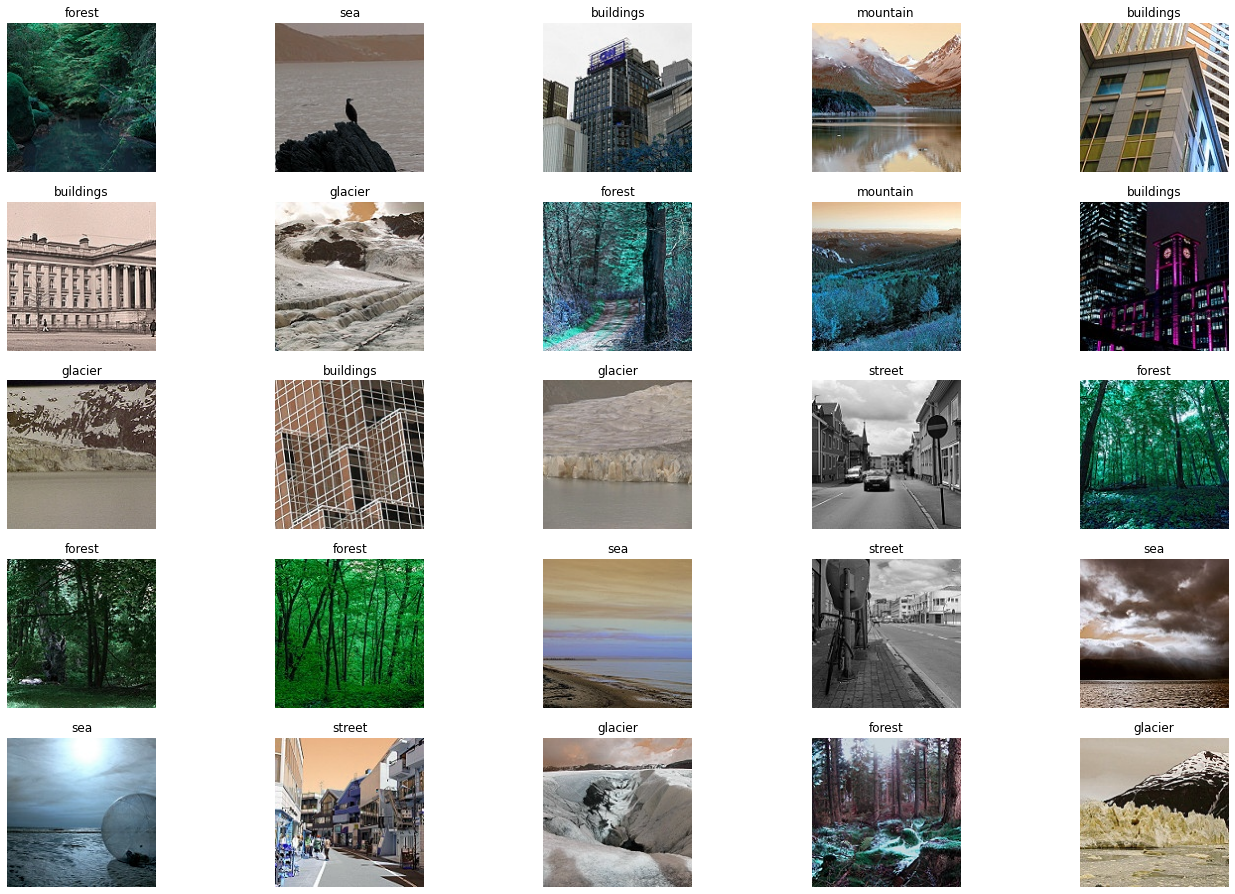

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(150,150,3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
base_model.trainable = False # freezing the trainable hyperparemetes of the existing model. pre-trained model MobileNet V2


In [ ]:
'''Now that we have our base layer setup, we can add the classifier. 
Instead of flattening the feature map of the base layer we will use a global average pooling layer 
that will average the entire 5x5 area of each 2D feature map 
and return to us a single 1280 element vector per filter.'''
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(6)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

history = model.fit(Images, Labels, epochs=10, 
                    validation_data=(Images_test, Labels_test))

Epoch 1/10
439/439 [==============================] - 26s 40ms/step - loss: 1.5155 - accuracy: 0.3871 - val_loss: 0.9782 - val_accuracy: 0.6164
Epoch 2/10
439/439 [==============================] - 16s 37ms/step - loss: 0.9405 - accuracy: 0.6315 - val_loss: 0.8469 - val_accuracy: 0.6744
Epoch 3/10
439/439 [==============================] - 16s 37ms/step - loss: 0.8278 - accuracy: 0.6825 - val_loss: 0.7832 - val_accuracy: 0.7029
Epoch 4/10
439/439 [==============================] - 16s 37ms/step - loss: 0.7754 - accuracy: 0.7091 - val_loss: 0.7447 - val_accuracy: 0.7188
Epoch 5/10
439/439 [==============================] - 17s 38ms/step - loss: 0.7444 - accuracy: 0.7207 - val_loss: 0.7176 - val_accuracy: 0.7304
Epoch 6/10
439/439 [==============================] - 17s 39ms/step - loss: 0.7113 - accuracy: 0.7352 - val_loss: 0.7010 - val_accuracy: 0.7374
Epoch 7/10
439/439 [==============================] - 17s 39ms/step - loss: 0.6930 - accuracy: 0.7345 - val_loss: 0.6851 - val_accuracy:

In [ ]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

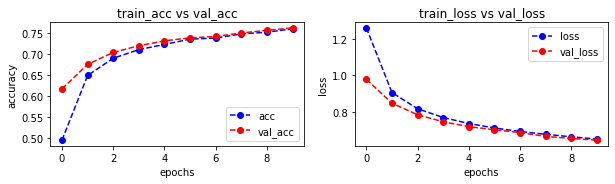

In [ ]:
plot_accuracy_loss(history)

In [ ]:
test_images,test_labels = get_images('/content/seg_test/seg_test/')

test_label = test_labels
test_images = np.array(test_images)
test_labels = np.array(test_label)

model.evaluate(test_images,test_labels, verbose=1)

94/94 [==============================] - 2s 21ms/step - loss: 0.6801 - accuracy: 0.7493


[0.6801114678382874, 0.7493333220481873]